<a href="https://colab.research.google.com/github/shrutishibu/python-and-statistics-for-financial-analysis/blob/main/Python_and_Statistics_for_Financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple trading strategy using moving averages

In [91]:
#required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import statsmodels.formula.api as smf
%matplotlib inline
#displays plot within the notebook

In [37]:
#read from csv files and store as dataframes
fb = pd.read_csv('/facebook.csv')
fb.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,20.400000,20.510000,19.990000,20.049999,19.459270,4157500
1,2015-01-02,20.129999,20.280001,19.809999,20.129999,19.536913,2842000
2,2015-01-05,20.129999,20.190001,19.700001,19.790001,19.206934,4948800
3,2015-01-06,19.820000,19.840000,19.170000,19.190001,18.624611,4944100
4,2015-01-07,19.330000,19.500000,19.080000,19.139999,18.576082,8045200


In [39]:
#moving averages for simple trading strategy
fb['MA10'] = fb['Close'].rolling(window=10).mean() #fast signal
fb['MA50'] = fb['Close'].rolling(window=50).mean() #slow signal
fb = fb.dropna().copy()
#generate trading signals: long (1) if MA10 > MA50, otherwise 0
fb.loc[:,'Shares'] = (fb['MA10'] > fb['MA50']).astype(int)
#add a column for the next day's closing prices
fb.loc[:,'Close1'] = fb['Close'].shift(-1)
#calculate profit: difference in closing prices if long, otherwise 0
fb.loc[:,'Profit'] = (fb['Close1'] - fb['Close']).where(fb['Shares'] == 1, 0)
fb.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Shares,Close1,Profit
98,2015-05-22,20.940001,21.020000,20.809999,20.860001,20.417433,5314800,21.010,21.9398,0,20.730000,0.0
99,2015-05-26,20.760000,20.900000,20.570000,20.730000,20.290192,6493300,21.020,21.9004,0,21.840000,0.0
100,2015-05-27,20.870001,21.940001,20.799999,21.840000,21.376638,10808300,21.121,21.8778,0,22.139999,0.0
101,2015-05-28,21.840000,22.209999,21.799999,22.139999,21.670277,8191400,21.240,21.8556,0,22.129999,0.0
102,2015-05-29,22.139999,22.280001,22.100000,22.129999,21.660488,8324900,21.324,21.8408,0,22.379999,0.0


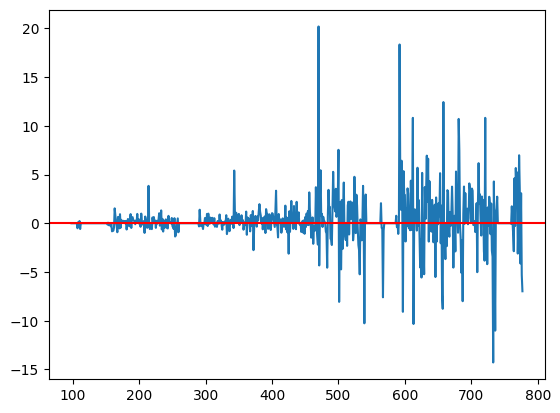

In [40]:
#plotting profit
fb['Profit'].plot()
plt.axhline(y=0, color='red')

In [41]:
#calculating accumalated wealth
fb['wealth'] = fb['Profit'].cumsum()
fb.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,Shares,Close1,Profit,wealth
774,2018-01-29,242.740005,248.110001,240.610001,246.850006,246.850006,11377900,233.431003,209.375201,1,242.720001,-4.130005,178.980010
775,2018-01-30,241.110001,246.419998,238.410004,242.720001,242.720001,14270800,235.692003,210.030001,1,245.800003,3.080002,182.060012
776,2018-01-31,245.770004,249.270004,244.449997,245.800003,245.800003,11964400,237.800003,210.713801,1,240.500000,-5.300003,176.760009
777,2018-02-01,238.520004,246.899994,238.059998,240.500000,240.500000,12980600,239.406003,211.296601,1,233.520004,-6.979996,169.780013
778,2018-02-02,237.000000,237.970001,231.169998,233.520004,233.520004,17961600,239.747003,211.685401,1,NaN,NaN,NaN


Text(0.5, 1.0, 'Total money you win is 169.78001300000003')

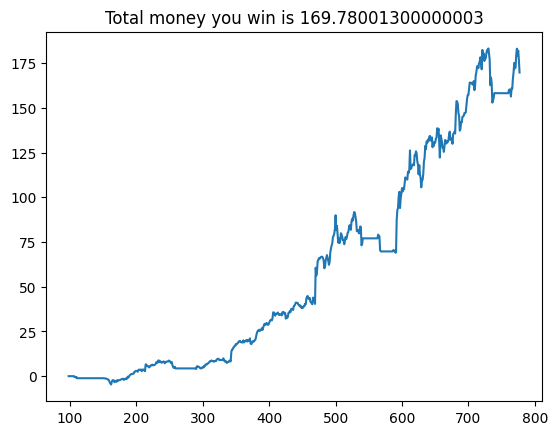

In [42]:
#plotting wealth to show growth of profit
fb['wealth'].plot()
plt.title('Total money you win is {}'.format(fb.loc[fb.index[-2], 'wealth']))

# Models of stock return

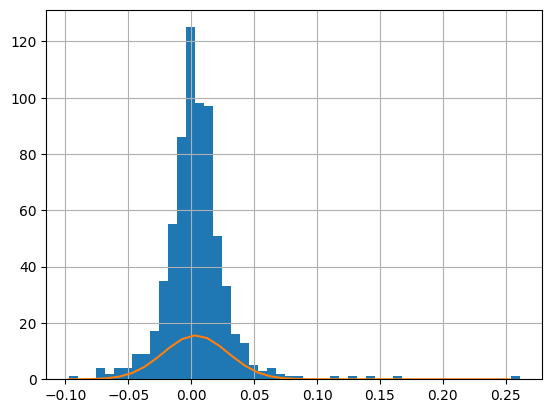

In [43]:
#calculating log returns
fb['log_return'] = np.log(fb['Close1']) - np.log(fb['Close'])
#plotting histogram of log return
mu = fb['log_return'].mean()
sigma = fb['log_return'].std(ddof=1)
density = pd.DataFrame()
density['X'] = np.arange(fb['log_return'].min(), fb['log_return'].max(), 0.01)
density['pdf'] = norm.pdf(density['X'], mu, sigma)
fb['log_return'].hist(bins=50)
plt.plot(density['X'], density['pdf'])
plt.show()

In [44]:
#probability whether stock price would fall in a certain day by 5%
prob_1 = norm.cdf(-0.05, mu, sigma)
print(prob_1)
#probability whether stock price would fall in a certain day by 10%
prob_2 = norm.cdf(-0.1, mu, sigma)
print(prob_2)

0.01815394343675641
2.5821320562235308e-05


In [45]:
#probability that stock price would fall in a year
#there are 220 estimated days in the market in a year
mu220 = 220*mu
sigma220 = (220**0.5)*sigma
prob_year = norm.cdf(-0.2, mu220, sigma220)
print(prob_year)

0.0048445278912097


In [46]:
#calculating value at risk
#single day VaR
#also called 5% quantile (change percentage accordingly)
var = norm.ppf(0.05, mu, sigma)
print(var)

-0.03852429790687481


# Sampling and interference

In [47]:
#sampling and finding statistics of logreturn
sample_size = fb['log_return'].shape[0]
sample_mean = fb['log_return'].mean() #sample mean
sample_std = fb['log_return'].std(ddof=1) #sample standard deviation
sample_sem = fb['log_return'].std(ddof=1) / sample_size**0.5 #sample standard error of mean

#90% confidence interval
#left and right quantile
z_left = norm.ppf(0.05, sample_mean, sample_std)
z_right = norm.ppf(0.95, sample_mean, sample_std)
#upper and lower bound
lower_bound = sample_mean - z_left * sample_std
upper_bound = sample_mean + z_right * sample_std
print("90% Confidence interval is in the interval: ", (lower_bound, upper_bound))

90% Confidence interval is in the interval:  (0.004537585348956945, 0.004719315795579433)


# Hypothesis testing
1. Setting up hypothesis

> H0:μ=0 - Null Hypothesis

> Ha:μ≠0 - Alternate Hypothesis

> H0 means the average stock return is 0 Ha means the average stock return is not equal to 0

2. Calculate test statistic

3. Set decision criteria

4. Make decision - shall we reject H0?

In [48]:
zhat = sample_mean / (sample_std / np.sqrt(sample_size))
print(zhat)

3.6236685873260144


In [49]:
alpha = 0.05 #confidence level
zleft = norm.ppf(alpha/2, 0, 1)
zright = -zleft #zright is negative of zleft
print(zleft, zright)

-1.9599639845400545 1.9599639845400545


In [50]:
print("At significance level {}, should we reject null hypothesis: {} ".format(alpha, zhat>zright or zhat<zleft ))

At significance level 0.05, should we reject null hypothesis: True 


In [51]:
#Alternate method: Checking using pvalue
p = 1 - norm.cdf(zhat, 0, 1)
print(p)

0.00014522686638429594


In [52]:
print("At significance level {}, should we reject null hypothesis: {} ".format(alpha, p<alpha))

At significance level 0.05, should we reject null hypothesis: True 


# Linear regression models for Financial Analysis

In [53]:
#Loading housing dataset
housing = pd.read_csv('/housing.csv')
housing.head()

,Unnamed: 0,LSTAT,INDUS,NOX,RM,MEDV
0,0,4.98,2.31,0.538,6.575,24.0
1,1,9.14,7.07,0.469,6.421,21.6
2,2,4.03,7.07,0.469,7.185,34.7
3,3,2.94,2.18,0.458,6.998,33.4
4,4,5.33,2.18,0.458,7.147,36.2


In [54]:
#Covariance
housing.cov()

,Unnamed: 0,LSTAT,INDUS,NOX,RM,MEDV
Unnamed: 0,21378.500000,269.868842,400.668663,6.755757,-8.215627,-304.723960
LSTAT,269.868842,50.994760,29.580270,0.488946,-3.079741,-48.447538
INDUS,400.668663,29.580270,47.064442,0.607074,-1.887957,-30.520823
NOX,6.755757,0.488946,0.607074,0.013428,-0.024603,-0.455412
RM,-8.215627,-3.079741,-1.887957,-0.024603,0.493671,4.493446
MEDV,-304.723960,-48.447538,-30.520823,-0.455412,4.493446,84.586724


In [55]:
#Correlation
housing.corr()

,Unnamed: 0,LSTAT,INDUS,NOX,RM,MEDV
Unnamed: 0,1.000000,0.258465,0.399439,0.398736,-0.079971,-0.226604
LSTAT,0.258465,1.000000,0.603800,0.590879,-0.613808,-0.737663
INDUS,0.399439,0.603800,1.000000,0.763651,-0.391676,-0.483725
NOX,0.398736,0.590879,0.763651,1.000000,-0.302188,-0.427321
RM,-0.079971,-0.613808,-0.391676,-0.302188,1.000000,0.695360
MEDV,-0.226604,-0.737663,-0.483725,-0.427321,0.695360,1.000000


array([[<Axes: xlabel='Unnamed: 0', ylabel='Unnamed: 0'>,
        <Axes: xlabel='LSTAT', ylabel='Unnamed: 0'>,
        <Axes: xlabel='INDUS', ylabel='Unnamed: 0'>,
        <Axes: xlabel='NOX', ylabel='Unnamed: 0'>,
        <Axes: xlabel='RM', ylabel='Unnamed: 0'>,
        <Axes: xlabel='MEDV', ylabel='Unnamed: 0'>],
       [<Axes: xlabel='Unnamed: 0', ylabel='LSTAT'>,
        <Axes: xlabel='LSTAT', ylabel='LSTAT'>,
        <Axes: xlabel='INDUS', ylabel='LSTAT'>,
        <Axes: xlabel='NOX', ylabel='LSTAT'>,
        <Axes: xlabel='RM', ylabel='LSTAT'>,
        <Axes: xlabel='MEDV', ylabel='LSTAT'>],
       [<Axes: xlabel='Unnamed: 0', ylabel='INDUS'>,
        <Axes: xlabel='LSTAT', ylabel='INDUS'>,
        <Axes: xlabel='INDUS', ylabel='INDUS'>,
        <Axes: xlabel='NOX', ylabel='INDUS'>,
        <Axes: xlabel='RM', ylabel='INDUS'>,
        <Axes: xlabel='MEDV', ylabel='INDUS'>],
       [<Axes: xlabel='Unnamed: 0', ylabel='NOX'>,
        <Axes: xlabel='LSTAT', ylabel='NOX'>,
        <

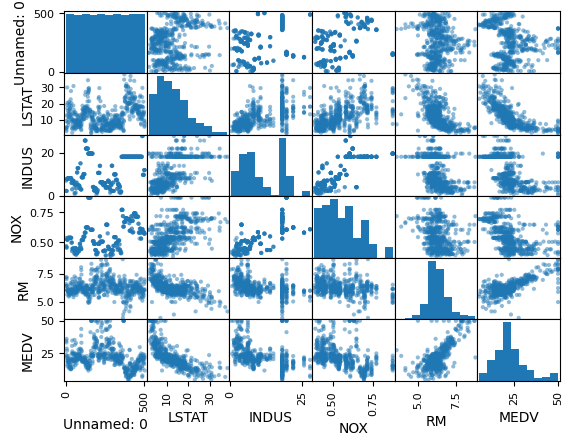

In [59]:
#creating scatter plot to show various correlations
from pandas.plotting import scatter_matrix #in jupyter notebook import from pandas.tools.plotting
scatter_matrix(housing)

<Axes: xlabel='LSTAT', ylabel='MEDV'>

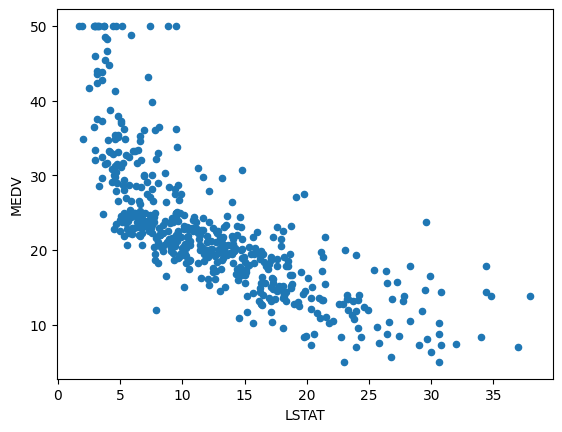

In [60]:
#Association between LSTAT and MEDV
housing.plot(kind='scatter', x='LSTAT', y='MEDV')

<Axes: xlabel='MA10', ylabel='MA50'>

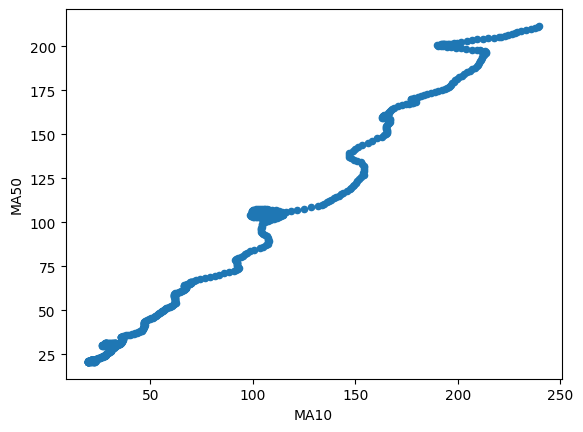

In [63]:
#trying to plot fb variables
fb.plot(kind="scatter", x="MA10", y="MA50")

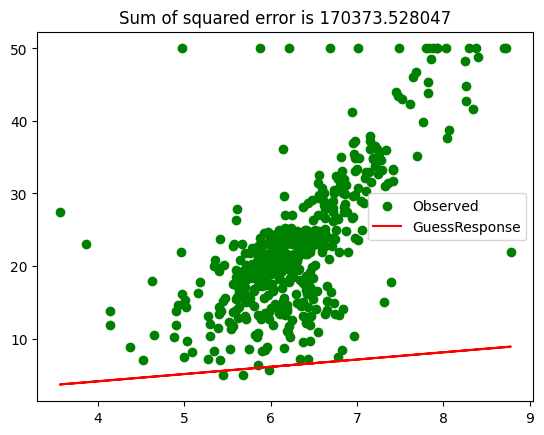

In [73]:
#Simple linear regression model based on association between RM and MEDV of housing model
#Guessing
b0 = 0.1 #intercept
b1 = 1 #slope
housing["guessResponse"] = b0 + b1 * housing["RM"]
#observed error
housing["error"] = housing["MEDV"] - housing["guessResponse"]
#sum of squared error as the title of the graph
plt.title("Sum of squared error is {}".format((((housing['error'])**2)).sum()))
#plotting observed data
plt.scatter(housing['RM'], housing['MEDV'], color='g', label='Observed')
#plotting guessed response
plt.plot(housing['RM'], housing['guessResponse'], color='red', label='GuessResponse')
plt.legend()
plt.show()

In [76]:
#least square estimates
formula = 'MEDV~LSTAT'
model = smf.ols(formula, housing).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 31 May 2024   Prob (F-statistic):           5.08e-88
Time:                        13:07:20   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

In [77]:
#estimating model's intercept and slope using least square estimation
b0 = model.params[0]
b1 = model.params[1]
#params attribute returns list of estimated parameters
print(b0, b1)

34.55384087938308 -0.9500493537579922


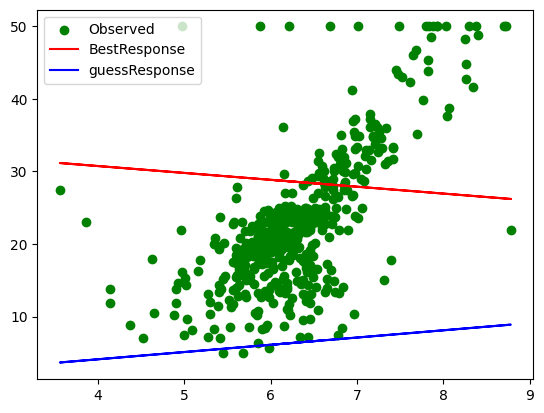

In [79]:
#using estimated paramters
housing["bestResponse"] = b0 + b1 * housing["RM"]
#plotting observed data
plt.scatter(housing['RM'], housing['MEDV'], color='g', label='Observed')
#plotting estimated response
plt.plot(housing['RM'], housing['bestResponse'], color='red', label='BestResponse')
#plotting guessed response
plt.plot(housing['RM'], housing['guessResponse'], color='blue', label='guessResponse')
plt.legend()
plt.show()

In [85]:
#Diagnostics
#Variables used are LSTAT and MEDV
housing["bestResponse"] = b0 + b1 * housing["LSTAT"]

<Axes: xlabel='LSTAT', ylabel='MEDV'>

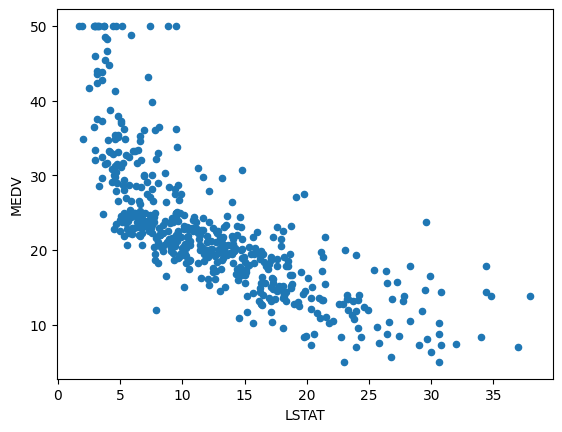

In [84]:
#Linearity
housing.plot(kind='scatter', x='LSTAT', y='MEDV')

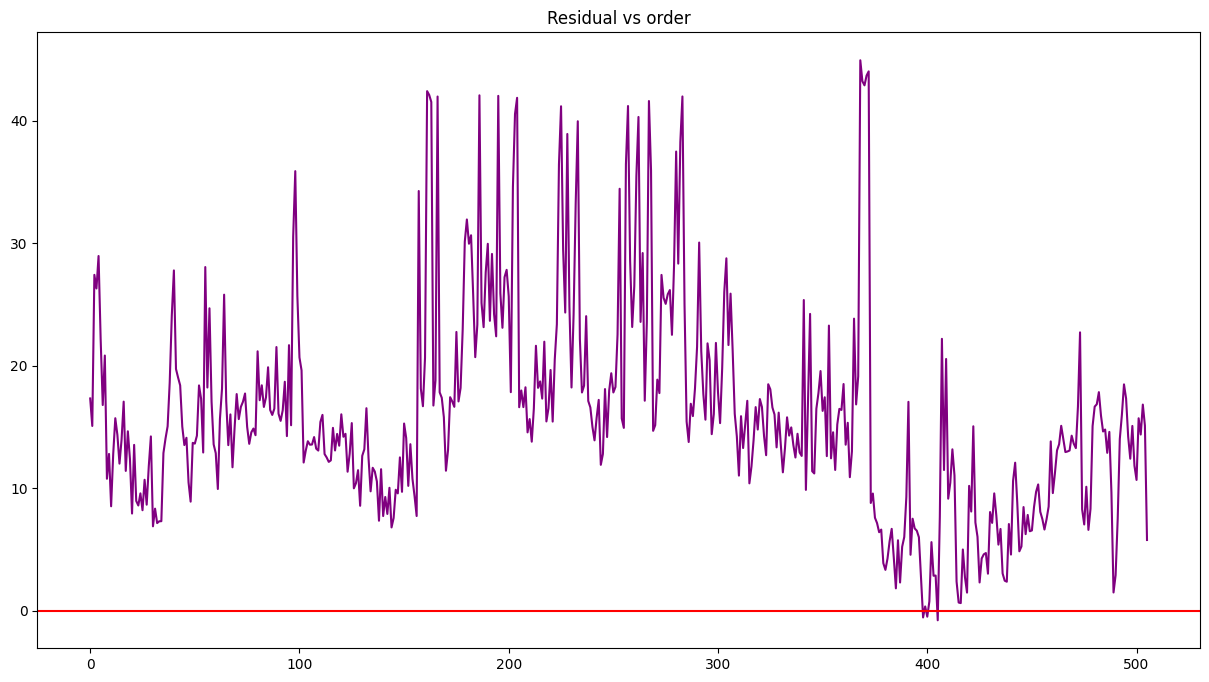

In [87]:
#Independence
housing["Error"] = housing["MEDV"] - housing["bestResponse"]
plt.figure(figsize=(15, 8))
plt.title('Residual vs order')
plt.plot(housing.index, housing['error'], color='purple')
plt.axhline(y=0, color='red')
plt.show()

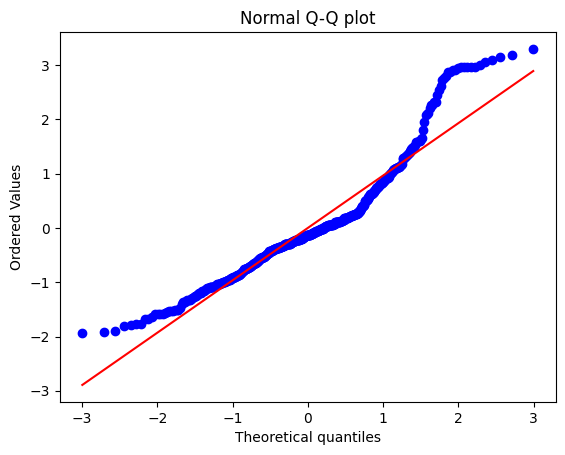

In [92]:
#normality
z = (housing['error'] - housing['error'].mean())/housing['error'].std(ddof=1)
stats.probplot(z, dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.show()

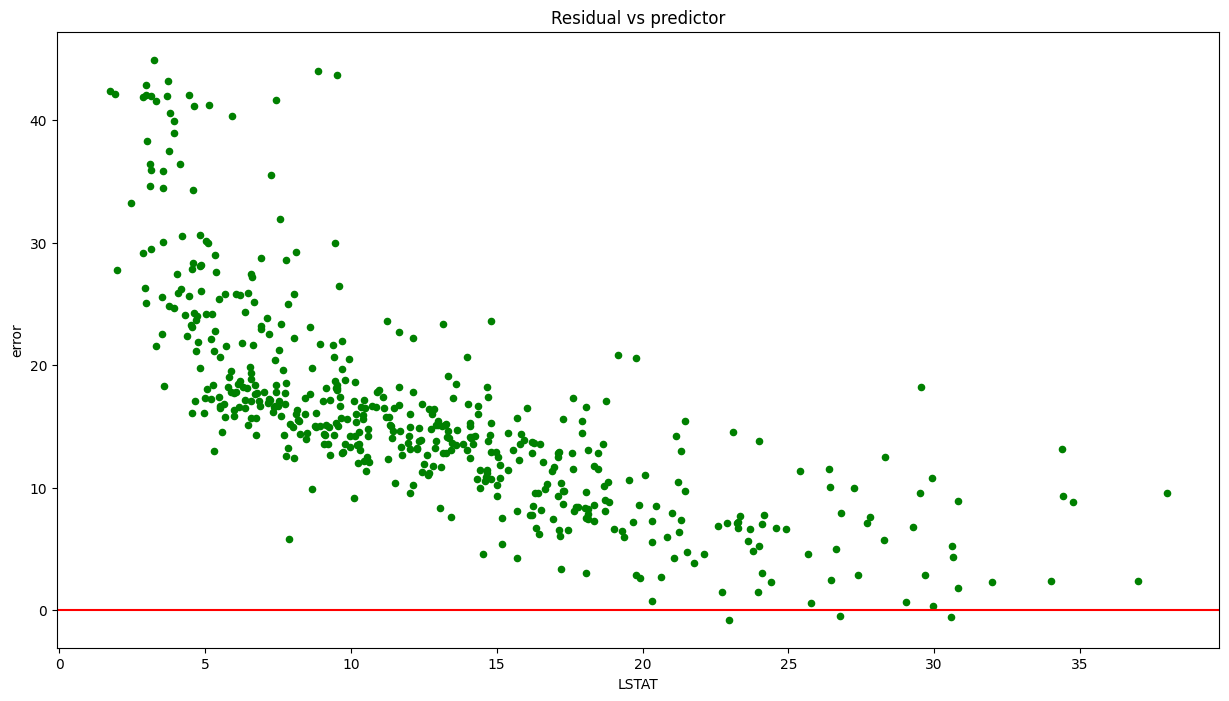

In [93]:
#equal variance
housing.plot(kind='scatter', x='LSTAT', y='error', figsize=(15, 8), color='green')
plt.title('Residual vs predictor')
plt.axhline(y=0, color='red')
plt.show()

In [98]:
#LSTAT~MEDV model violates all 4 assumptions
#Therefore we cannot make inference based on this model

# Building multiple regression model

In [94]:
import warnings
warnings.filterwarnings("ignore")
#ignores all warnings

In [101]:
#importing stock data
indicepanel = pd.read_csv('/indicepanel.csv')
indicepanel.head()

,Date,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
0,2008-01-04,-1.529998,-1.570008,-3.540039,-40.879883,2.43945,5.489746,-27.990235,-2.300293,515.349609,-464.320313,143.339996
1,2008-01-07,0.270004,-1.529998,-29.940064,-56.930176,-245.40918,-111.689941,-102.709961,-27.500000,216.951171,-48.830078,141.809998
2,2008-01-08,-2.990006,0.270004,1.640015,-7.179931,19.75000,44.509766,33.680176,-33.899902,-354.060547,99.370117,142.080002
3,2008-01-09,0.589997,-2.990006,-25.459961,-63.119873,-230.69043,-17.109864,-5.270020,-12.900390,768.359375,234.450195,139.089996
4,2008-01-10,1.100006,0.589997,16.530029,8.270019,142.90039,9.140137,-40.120117,-100.200196,-195.560547,-158.209961,139.679993


In [115]:
#replacing null values
indicepanel = indicepanel.fillna(method='ffill')
indicepanel = indicepanel.dropna()

In [116]:
print(indicepanel.shape)

(2677, 12)


In [118]:
#splitting data into training and testing data
Train = indicepanel.iloc[-2000:-1000, :]
Test = indicepanel.iloc[-1000:, :]
print(Train.shape, Test.shape)

(1000, 12) (1000, 12)


array([[<Axes: xlabel='spy', ylabel='spy'>,
        <Axes: xlabel='spy_lag1', ylabel='spy'>,
        <Axes: xlabel='sp500', ylabel='spy'>,
        <Axes: xlabel='nasdaq', ylabel='spy'>,
        <Axes: xlabel='dji', ylabel='spy'>,
        <Axes: xlabel='cac40', ylabel='spy'>,
        <Axes: xlabel='daxi', ylabel='spy'>,
        <Axes: xlabel='aord', ylabel='spy'>,
        <Axes: xlabel='hsi', ylabel='spy'>,
        <Axes: xlabel='nikkei', ylabel='spy'>,
        <Axes: xlabel='Price', ylabel='spy'>],
       [<Axes: xlabel='spy', ylabel='spy_lag1'>,
        <Axes: xlabel='spy_lag1', ylabel='spy_lag1'>,
        <Axes: xlabel='sp500', ylabel='spy_lag1'>,
        <Axes: xlabel='nasdaq', ylabel='spy_lag1'>,
        <Axes: xlabel='dji', ylabel='spy_lag1'>,
        <Axes: xlabel='cac40', ylabel='spy_lag1'>,
        <Axes: xlabel='daxi', ylabel='spy_lag1'>,
        <Axes: xlabel='aord', ylabel='spy_lag1'>,
        <Axes: xlabel='hsi', ylabel='spy_lag1'>,
        <Axes: xlabel='nikkei', ylabel='s

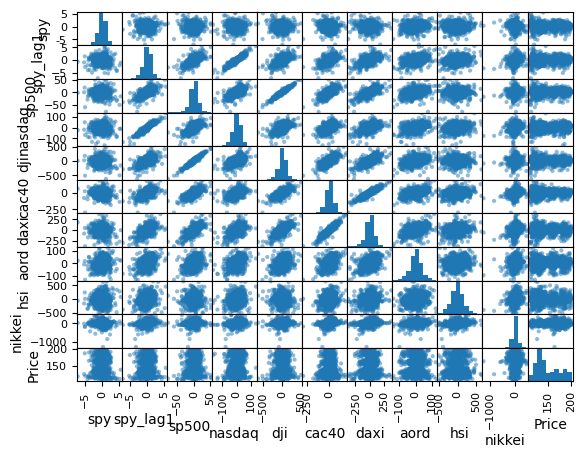

In [119]:
#exploring data
scatter_matrix(Train)

In [122]:
#to fit an Ordinary Least Squares (OLS) regression model
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+aord+daxi+nikkei+hsi'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     7.962
Date:                Fri, 31 May 2024   Prob (F-statistic):           1.97e-11
Time:                        14:28:40   Log-Likelihood:                -1617.7
No. Observations:                1000   AIC:                             3255.
Df Residuals:                     990   BIC:                             3305.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0836      0.039      2.138      0.033       0.007       0.160
spy_lag1      -0.1567      0.091     -1.730      0.084      -0.335       0.021
sp500          0.0221      0.014      1.621      0.105      -0.005       0.049
nasdaq         0.0040      0.004      1.066      0.287      -0.003       0.011
dji           -0.0018      0.001     -1.248      0.212      -0.005       0.001
cac40         -0.0003      0.002     -0.153      0.879      -0.004       0.004
aord           0.0093      0.001      7.492      0.000       0.007       0.012
daxi          -0.0025      0.001     -2.387      0.017      -0.005      -0.000
nikkei        -0.0004      0.000     -1.264      0.207      -0.001       0.000
hsi            0.0003      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                       91.018   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.687
Skew:                          -0.450   Prob(JB):                     7.45e-59
Kurtosis:                       5.369   Cond. No.                         405.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

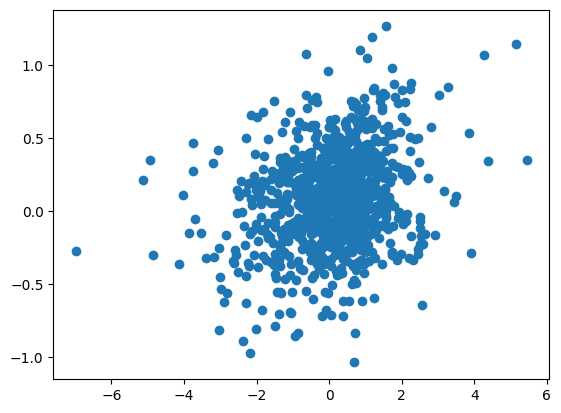

In [123]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)
plt.scatter(Train['spy'], Train['PredictedY'])

In [124]:
#Evaluation using statistical standards
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    r2 = SSR/SST
    adjustR2 = 1 - (1-r2)*(data.shape[0] - 1)/(data.shape[0] -model_k -1)
    RMSE = (SSE/(data.shape[0] -model_k -1))**0.5
    return adjustR2, RMSE

In [125]:
def assessTable(test, train, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessment = pd.DataFrame(index=['R2', 'RMSE'], columns=['Train', 'Test'])
    assessment['Train'] = [r2train, RMSEtrain]
    assessment['Test'] = [r2test, RMSEtest]
    return assessment

In [126]:
# Get the assement table fo our model
assessTable(Test, Train, lm, 9, 'aord')

,Train,Test
R2,-0.007459,-0.008721
RMSE,35.443706,42.893706


from matplotlib import pyplot as plt
_df_0['Train'].plot(kind='hist', bins=20, title='Train')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Test'].plot(kind='hist', bins=20, title='Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Train', y='Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Train']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Train'}, axis=1)
              .sort_values('Train', ascending=True))
  xs = counted['Train']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Train', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Train')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Test'}, axis=1)
              .sort_values('Test', ascending=True))
  xs = counted['Test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Test', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Train'].plot(kind='line', figsize=(8, 4), title='Train')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Test'].plot(kind='line', figsize=(8, 4), title='Test')
plt.gca().spines[['top', 'right']].set_visible(False)

# Evaluation of model

In [128]:
# Train
Train['Order'] = [1 if sig>0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']

Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())

Total profit made in Train:  214.34009500000042


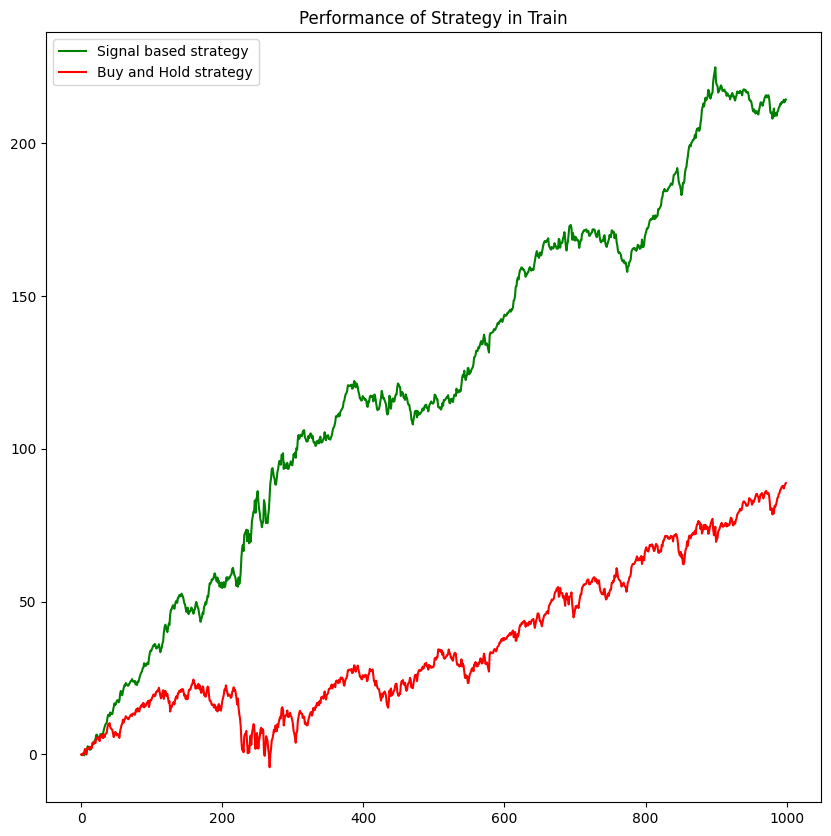

In [129]:
#profit of signal based strategy
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [132]:
# Test
Test['Order'] = [1 if sig>0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  241.0300879999996


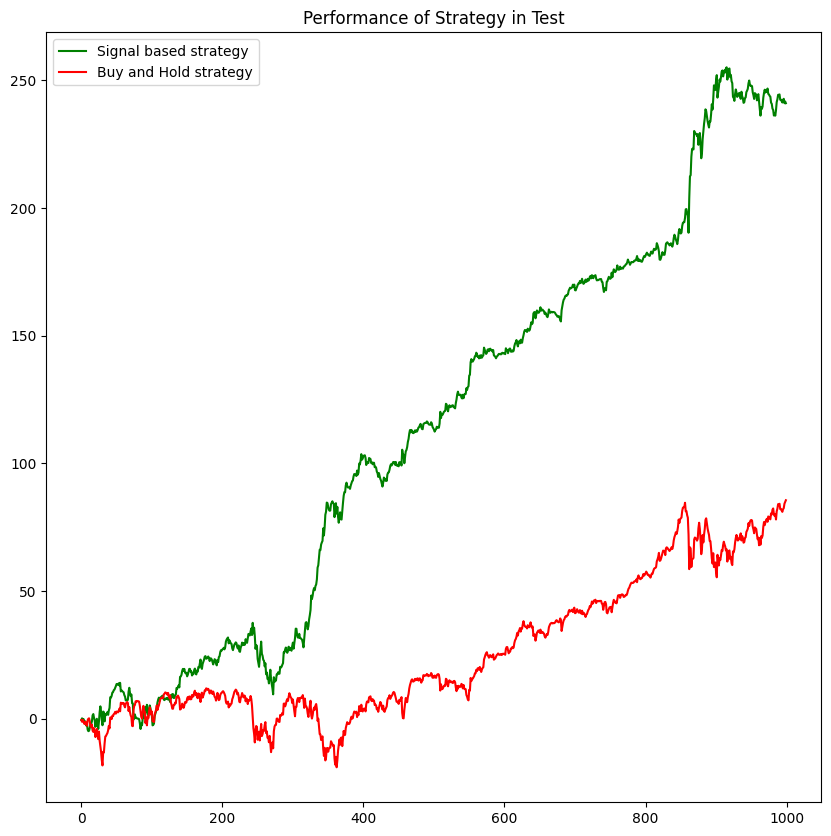

In [133]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(Test['Wealth'].values, color='green', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='red', label='Buy and Hold strategy')
plt.legend()
plt.show()

In [134]:
#evaluation of model using practical standard
Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

In [135]:
# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.17547331210929357
Yearly Sharpe Ratio is  2.785552473420058


In [136]:
# Sharpe Ratio in Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

print('Daily Sharpe Ratio is ', dailyr.mean()/dailyr.std(ddof=1))
print('Yearly Sharpe Ratio is ', (252**0.5)*dailyr.mean()/dailyr.std(ddof=1))

Daily Sharpe Ratio is  0.13035126208575046
Yearly Sharpe Ratio is  2.06926213537379


In [137]:
# Maximum Drawdown in Train data
Train['Peak'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['Peak'] - Train['Wealth'])/Train['Peak']
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.030981061849424625


In [138]:
# Maximum Drawdown in Test data
Test['Peak'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['Peak'] - Test['Wealth'])/Test['Peak']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.11719899524631659
